In [5]:
%matplotlib inline
from random import randint, shuffle, choice
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import os.path
import pandas as pd

In [781]:
cards_this_level = list(cards.items())

In [782]:
cards_this_level

[('monster', {}),
 ('treasure', {}),
 ('merchant', {}),
 ('resting', {}),
 ('event', {}),
 ('trap', {})]

In [740]:
cards_this_level = {'monster': {1:2}, 'treasure': {1:[2,3,4,5]}}

In [753]:
cards_this_level.keys()

dict_keys(['monster', 'treasure'])

In [776]:
list(cards_this_level.items())

[('monster', {1: 2}), ('treasure', {1: [2, 3, 4, 5]})]

In [758]:
choice(list(cards_this_level.items()))

('monster', {1: 2})

In [784]:
shuffle(cards_this_level)
print(cards_this_level.pop(), cards_this_level)

('event', {}) [('treasure', {}), ('merchant', {}), ('resting', {}), ('trap', {})]


In [1448]:
b = [[1,2], [3,4], [5,6,7], [8,9,10], [11,12,13,14]]
b[self.rank-1][-1:]

[7]

In [122]:
class MiniRogue:
    def __init__(self, armor, life, gold, food):
        self.armor = armor
        self.life = life
        self.gold = gold
        self.food = food
        self.xp = 0
        self.spells = []
        self.rank = 1
        self.alive = True
        self.all_rolls = []
        self.monster_killed_this_level = False
        self.cards_this_level = None
        self.dungeon_area = 1
        self.dungeon_level = 1
        self.cards = ['monster', 'treasure', 'merchant', 'resting', 'event', 'trap']
        self.blueprints = [[1,2], [3,4], [5,6,7], [8,9,10], [11,12,13,14]]
        self.level_names = [0, "Black Sewers", "Poisonous Dungeon", "Undead Catacombs", "Flaming Underworld", "Sunken Keep of Og"]
        self.boss_names = [0, "Undead Soldier", "Skeleton", "Undead Knight", "Serpent Knight", "Og's Sanctum Guard"]
        self.monster_life = 0
        self.monster_dmg = 0
        self.monster_reward = 0
        self.boss_gold = 0
        self.win = False
        self.difficulty = 0
        self.spell_effects = {'fireball': 'Inflict 8 damage to a monster.',
                              'ice': 'Freeze a monster for one turn (no counter-attack).',
                              'poison': 'Inflict 5 extra damage per turn.',
                              'healing': 'Gain 8 HP.'}
        self.ice_active = False
        self.poison_active = False
        
        
    def save_game(self):
        save = [self.armor, self.life, self.gold, self.food, self.xp, self.spells, self.rank, self.dungeon_area, self.dungeon_level, self.difficulty]
        with open("rogue_save.txt", "wb") as f:
            pickle.dump(save, f)
        
        
    def load_game(self):
        with open("rogue_save.txt", "rb") as f:
            load = pickle.load(f)
        self.armor, self.life, self.gold, self.food, self.xp, self.spells, self.rank, self.dungeon_area, self.dungeon_level, self.difficulty = load
        
        
    def start(self):
        if os.path.isfile('rogue_save.txt'):
            load_game = input("Continue previous game? [y/n]")
            if load_game == 'y':
                self.load_game()
                self.stats(mode='all')
                self.explore_area()
        else:
            print("\nYou've entered the cave to Level 1: Black Sewers\n")
            self.stats(mode='char')
            if self.gold == 5: self.difficulty = 0
            elif self.gold == 3: self.difficulty = 2
            elif self.gold == 2: self.difficulty = 4
            elif self.gold == 1: self.difficulty = 6
            self.explore_area()
    
    
    def stats(self, mode='all'):
        if not self.spells:
            spells = None
        else:
            spells = self.spells
        if mode == 'all':
            print("Character stats: HP {} | Armor {} | Gold {} | Food {} | XP {} | Rank {} | Spells {}".format(
            self.life, self.armor, self.gold, self.food, self.xp, self.rank, spells))
            print("Dungeon stats: Level {} ({}) | Area {}".format(self.dungeon_level, self.level_names[self.dungeon_level], self.dungeon_area))
        elif mode == 'char':
            print("Character stats: HP {} | Armor {} | Gold {} | Food {} | XP {} | Rank {} | Spells {}".format(
            self.life, self.armor, self.gold, self.food, self.xp, self.rank, spells))
        elif mode == 'monster':
            print("Monster stats: HP {} | Dmg {} | Reward: {} XP".format(self.monster_life, self.monster_dmg, self.monster_reward))
        elif mode == 'boss' and self.dungeon_level < 5:
            print("Boss stats: HP {} | Dmg {} | Rewards: {} XP + {} Gold + Item".format(self.monster_life, self.monster_dmg, self.monster_reward, self.boss_gold))
        elif mode == 'boss' and self.dungeon_level == 5:
            print("Boss stats: HP {} | Dmg {} | Reward: Og's Blood".format(self.monster_life, self.monster_dmg))
    
    
    def lose_life(self, life):
        self.life -= life
        print("You lost {} HP. You have {} HP left.".format(life, self.life))
        if self.life <= 0:
            self.alive = False
            print("Here's you dice distribution over this game:")
            self.plot_die()
            self.final_score()
            sys.exit("You died. Game over.")
            
    
    def new_dungeon_area(self):
        self.dungeon_area += 1
        if self.dungeon_area == 3:
            self.dungeon_level = 2
            print("\nYou've descended to Level 2: the Poisonous Dungeon\n")
        elif self.dungeon_area == 5:
            self.dungeon_level = 3
            print("\nYou've descended to Level 3: Undead Catacombs\n")
        elif self.dungeon_area == 8:
            self.dungeon_level = 4
            print("\nYou've descended to Level 4: Flaming Underworld\n")
        elif self.dungeon_area == 11:
            self.dungeon_level = 5
            print("\nYou've descended to Level 5: Sunken Keep of Og\n")
        self.monster_killed_this_level = False
        if self.food:
            self.food -= 1
            print("You've consumed 1 food before going into the next area.")
            print("You have {} food left.".format(self.food))
        else:
            self.lose_life(2)
            print("You didn't have any food to consume before the next area, so you lost 2 HP.")
            print("You have {} HP left.".format(self.life))
        self.explore_area()
        
        
    def gain_xp(self, xp=0):
        self.xp += xp
        if self.xp >= self.rank*6:
            extra_xp = self.xp - self.rank*6
            self.rank += 1
            if self.rank < 5:
                self.xp = extra_xp
                print("\n>> You've leveled up to Rank {0}! Now you can use {0} dice. <<\n".format(self.rank))
            self.rank = min(self.rank, 4)
        elif self.xp < 0 and self.rank == 1:
            self.xp = 0
        elif self.xp < 0:
            self.rank -= 1
            self.xp = self.rank*6 + self.xp
            print("\n>> You've lost a level, back to Rank {0}! Now you can only use {0} dice. <<\n".format(self.rank))
        if self.rank == 4:
            self.life += 1
            print("\n> Max rank, xp gained gives you +1 HP! <")
            print("You have {} HP.".format(self.life))
        
        
    def roll_die(self, sides=6, dies=1):
        total = 0
        for die in range(dies):
            n = randint(1, sides)
            self.all_rolls.append(n)
            total += n
            print('d{} roll: {}'.format(sides, n))
        return total
        
        
    def roll_combat_die(self, sides=6, dies=1, feat_roll=False):
        ones = []
        sixes = []
        total = 0
        critical = False
        for die in range(dies):
            n = randint(1, sides)
            if not feat_roll:
                self.all_rolls.append(n)
            if n == 1:
                ones.append(n)
                print('d{} roll: {} -> missed!'.format(sides, n))
            elif n == 6:
                sixes.append(n)
                print('d{} roll: {} -> critical!'.format(sides, n))
                total += n
            else:
                print('d{} roll: {}'.format(sides, n))
                total += n
        print("You've rolled a total of {}".format(total))
        if sixes:
            print("You've got {} critical hit(s).".format(len(sixes)))
            for i in range(len(sixes)):
                print("Would you like to reroll your critical die #{} of {} [y/n]?".format(i+1, len(sixes)))
                reroll = input().lower()
                self.nxt()
                if reroll == 'yes' or reroll == 'y':
                    critical = self.roll_combat_die(sides=sides, dies=1, feat_roll=True)
                    if critical == 0:
                        total -= 6
                        print("Oops, that 6 was wasted. Your total now is {}".format(total))
                    else:
                        total += critical
                        print("Critical hit! Your total now is {}".format(total))
        if not feat_roll:
            available_dice = self.all_rolls[-dies:]
            available_dice = [d for d in available_dice if not d == 6]
            new_dice = []
            while len(available_dice) > 0:
                print("Your total attack now is {}".format(total))
                feat = input("Would you like to attempt a feat? Reroll a die one time by paying 2 HP or 1 XP. \nAvailable dice: {} [y/n]".format(available_dice))
                while not check(feat, ['y', 'n']):
                    feat = input("Would you like to attempt a feat? Reroll a die one time by paying 2 HP or 1 XP. \nAvailable dice: {} [y/n]".format(available_dice))
                self.nxt()
                if feat == 'y':
                    new_die, old_die, available_dice = self.feat_checker(available_dice)
                    new_dice.append(new_die)
                    if old_die != 1:
                        total -= old_die
                    total += new_die
                else:
                    break

        return total
    
    
    def feat_checker(self, available_dice):
        new_dice = []
        print("\nChoose a die to reroll:")
        for idx, die in enumerate(available_dice):
            print("[{}] {}".format(idx+1, die))
        reroll = int(input("\n"))
        while not check(reroll, range(1,idx+2)):
            reroll = int(input("\n"))
        self.nxt()
        print("What price will you pay for the power of despair to change this attack dice?")
        price = input("[1] Lose 1 XP \n[2] Lose 2 HP\n")
        while not check(price, ['1', '2']):
            price = input("[1] Lose 1 XP \n[2] Lose 2 HP\n")
        self.nxt()
        if price == '1':
            self.gain_xp(-1)
            print("You've lost 1 XP.")
        elif price == '2':
            self.lose_life(2)
        old_die = available_dice[reroll-1]
        del available_dice[reroll-1]
        new_die = self.roll_combat_die(dies=1, feat_roll=True)
        return new_die, old_die, available_dice
    
    
    def plot_die(self):
        plt.hist(self.all_rolls, bins=6);
        plt.show()
        
        
    def nxt(self):
        print("-"*85)
        
        
    def explore_area(self):
        cards_this_level = self.cards.copy()
        shuffle(cards_this_level)
        boss_area = self.dungeon_area == self.blueprints[self.dungeon_level-1][-1:][0]
        print("\nYou've entered Area {} from Level {}".format(self.dungeon_area, self.dungeon_level))
        self.save_game()
        print(">> Checkpoint - Game saved. <<")

        encounter_1 = cards_this_level.pop()
        if boss_area: print("Area {}: [X] -> 2[] -> [] -> 2[] -> Boss Monster".format(self.dungeon_area))
        else: print("Area {}: [X] -> 2[] -> [] -> 2[]".format(self.dungeon_area))
        print("You've encountered: {}".format(encounter_1))
        self.card_encounter(encounter_1)
        
        encounter_2a = cards_this_level.pop()
        encounter_2b = cards_this_level.pop()
        if boss_area: print("Area {}: [] -> 2[X] -> [] -> 2[] -> Boss Monster".format(self.dungeon_area))
        else: print("Area {}: [] -> 2[X] -> [] -> 2[]".format(self.dungeon_area))        
        print("You've encountered: {} and {}".format(encounter_2a, encounter_2b))
        print("Choose one to encounter:")
        choice = input("[1] {} \n[2] {}\n".format(encounter_2a, encounter_2b))
        while not check(choice, ['1','2']):
            choice = input("[1] {} \n[2] {}\n".format(encounter_2a, encounter_2b))
        self.nxt()
        if choice == '1': self.card_encounter(encounter_2a)
        elif choice == '2': self.card_encounter(encounter_2b)
        
        encounter_3 = cards_this_level.pop()
        if boss_area: print("Area {}: [] -> 2[] -> [X] -> 2[] -> Boss Monster".format(self.dungeon_area))
        else: print("Area {}: [] -> 2[] -> [X] -> 2[]".format(self.dungeon_area))
        print("You've encountered: {}".format(encounter_3))
        self.card_encounter(encounter_3)
        
        encounter_4a = cards_this_level.pop()
        encounter_4b = cards_this_level.pop()
        if boss_area: print("Area {}: [] -> 2[] -> [] -> 2[X] -> Boss Monster".format(self.dungeon_area))
        else: print("Area {}: [] -> 2[] -> [] -> 2[X]".format(self.dungeon_area))
        print("You've encountered: {} and {}".format(encounter_4a, encounter_4b)) 
        print("Choose one to encounter:")
        choice = input("[1] {} \n[2] {}\n".format(encounter_4a, encounter_4b))
        while not check(choice, ['1','2']):
            choice = input("[1] {} \n[2] {}\n".format(encounter_4a, encounter_4b))
        self.nxt()
        if choice == '1': self.card_encounter(encounter_4a)
        elif choice == '2': self.card_encounter(encounter_4b)
        
        if boss_area:
            print("\nArea {}: Boss Monster!!".format(self.dungeon_area))
            self.stats()
            print("\n======>> Boss Battle! <<======\n")
            print("Level {} Boss: {}".format(self.dungeon_level, self.boss_names[self.dungeon_level]))
            self.boss_encounter()
        self.new_dungeon_area()
        
        
    def add_spell(self, spell):
        if spell in ['fireball', 'healing', 'ice', 'poison']:
            self.spells.append(spell)
        if len(self.spells) > 2:
            print("You can only carry two spells, select one to discard:")
            for idx, s in enumerate(self.spells):
                print("[{}] {}".format(idx+1, s))
            discard = input()
            while not check(discard, ['1','2','3']):
                discard = input()
            self.nxt()
            del self.spells[int(discard)-1]
            
            
    def store(self):
        def check_gold(gold):
                if gold <= self.gold:
                    return True
                else:
                    print("Not enough gold.")
            
        print("\nWelcome to my store, valued customer! May I help you?")
        print("\nBuy:")
        print("[1] Ration: +1 food            $[1 gold]")
        print("[2] Health Potion: +1 HP       $[1 gold]")
        print("[3] Big Health Potion: +4 HP   $[3 gold]")
        print("[4] Armor Piece: +1 armor      $[6 gold]")
        print("[5] Any 1 spell                $[8 gold]")
        print("\nSell:")
        print("[6] Armor Piece                $[3 gold]")
        print("[7] Any 1 spell                $[4 gold]")
        print("\n[8] Exit\n")
        self.stats(mode='char')
        trade = int(input())
        while not check(trade, [1,2,3,4,5,6,7,8]):
            trade = int(input())
        self.nxt()
        if trade == 8:
            return
        elif trade == 1:
            n = int(input("How many Rations? "))
            self.nxt()
            if check_gold(n*1):
                print("Got +{} food".format(n))
                self.food += n
                self.gold -= n*1
        elif trade == 2:
            n = int(input("How many Health Potions? "))
            self.nxt()
            if check_gold(n*1):
                print("Got +{} HP".format(n))
                self.life += n
                self.gold -= n*1
        elif trade == 3:
            n = int(input("How many Big Health Potions? "))
            self.nxt()
            if check_gold(n*3):
                print("Got +{} HP".format(n*4))
                self.life += n*4
                self.gold -= n*3
        elif trade == 4:
            n = int(input("How many Armor Pieces? "))
            self.nxt()
            if check_gold(n*4):
                print("Got +{} armor piece".format(n))
                self.armor += n
                self.gold -= n*4
        elif trade == 5:
            spell_list = [0, 'fireball', 'ice', 'poison', 'healing']
            spell = int(input("\nWhat spell would you like to buy?\n[0] Cancel purchase \n[1] Fireball Spell - In combat, inflict 8 damage to a Monster \n[2] Ice Spell - In combat, freeze a Monster for one turn. The Monster does not counter-attack. \n[3] Poison Spell - In Combat, for the remainder of the Combat sequence, inflict 5 extra damage per turn. \n[4] Healing Spell - Gain 8 HP in Combat or before resolving a Room card.\n"))
            while not check(spell, [0,1,2,3,4]):
                spell = int(input("\nWhat spell would you like to buy?\n[0] Cancel purchase \n[1] Fireball \n[2] Ice \n[3] Poison \n[4] Healing\n"))
            self.nxt()
            if spell == 0:
                self.store()
            else:
                if check_gold(8):
                    print("Got {} spell".format(spell_list[spell]))
                    self.add_spell(spell_list[spell])
                    self.gold -= 8
        elif trade == 6:
            n = int(input("How many Armor pieces would you like to SELL for 3 gold? You have {} armor. ".format(self.armor)))
            self.nxt()
            if n <= self.armor:
                print("Sold {} armor piece(s).".format(n))
                self.armor -= n
                self.gold += n*3
            else:
                print("Not enough items to sell.")
        elif trade == 7:
            if self.spells:
                print("What spell would you like to SELL for 4 gold? You have:")
                print("[0] Cancel transaction")
                for idx, s in enumerate(self.spells):
                    print("[{}] {}".format(idx+1, s))
                spell = int(input())
                while not check(spell, range(0,idx+2)):
                    spell = int(input())
                self.nxt()
                if spell == 0:
                    self.store()
                else:
                    del self.spells[int(spell)-1]
                    print("Sold {} spell.".format(spell))
                    self.gold += 4
            else:
                print("You doesn't have any spells to sell.")
        
        self.stats(mode='char')
        repeat = input("\n Continue trading with merchant? [y/n] ").lower()[0]
        while not check(repeat, ['y', 'n']):
            repeat = input("\n Continue trading with merchant? [y/n] ").lower()[0]
        self.nxt()
        if repeat == 'y':
            self.store()
                
    
    def treasure(self, boss=False):
        r = 0
        if not boss:
            if self.monster_killed_this_level:
                print("\nSince you killed a monster in this area, you found 2 gold pieces!")
                self.gold += 2
                self.stats(mode='char')
            else:
                print("\nYou've found 1 gold piece.")
                self.gold += 1
                self.stats(mode='char')
            print("\nRoll a 5 or more on a die to find a special item. Press any key to roll.")
            _ = input()
            self.nxt()
            r = self.roll_die()
        if r >= 5 or boss:
            print("\nSweet, you've found a special item! Roll a die to discover it (press any key).")
            _ = input()
            self.nxt()
            n = self.roll_die()
            if n == 1:
                print("1: Armor Piece - Immediately gain 1 Armor.")
                self.armor += 1
                self.stats(mode='char')
            elif n == 2:
                print("2: Better Weapon - Immediately gain 2 XP.")
                self.gain_xp(2)
                self.stats(mode='char')
            elif n == 3:
                print("3: Fireball Spell - In combat, inflict 8 damage to a Monster")
                self.add_spell('fireball')
                self.stats(mode='char')
            elif n == 4:
                print("4: Ice Spell - In combat, freeze a Monster for one turn. The Monster does not counter-attack.")
                self.add_spell('ice')
                self.stats(mode='char')
            elif n == 5:
                print("5: Poison Spell - In Combat, for the remainder of the Combat sequence, inflict 5 extra damage per turn.")
                self.add_spell('poison')
                self.stats(mode='char')
            elif n == 6:
                print("6: Healing Spell - Gain 8 HP in Combat or before resolving a Room card.")
                self.add_spell('healing')
                self.stats(mode='char')
        else:
            print("Sorry, it was \"just\" gold...")
    
    
    def card_encounter(self, card):
        if card == 'resting':
            print("\nAh, resting... would you like to:")
            print("[1] Reinforce your Weapon: +1 XP \n[2] Search for Ration: +1 food \n[3] Heal: +2 HP")
            resting = input()
            while not check(resting, ['1','2','3']):
                resting = input()
            self.nxt()
            if resting == '1':
                self.gain_xp(1)
                print("You've got 1 XP.")
                self.stats(mode='char')
            elif resting == '2':
                self.food += 1
                print("You've got 1 food.")
                self.stats(mode='char')
            elif resting == '3':
                self.life += 2
                print("You've got 2 HP.")
                self.stats(mode='char')
                
        elif card == 'treasure':
            self.treasure()
                
        elif card == 'event':
            event_effects = [
                0,
                "1: Found Ration - You don’t know what this meat is, and you don’t care. Gain 1 Food.",
                "2: Found Health Potion - A Monster’s favorite drink. Might as well drink a sip too. Gain 2 HP.",
                "3: Found Loot - You’ve found a coin hidden in a crack between two stones. Gain 2 Gold.",
                "4: Found Whetstone - You’ve found a Monster’s blade sharpening tools. Gain 2 XP.",
                "5: Found Armor - A piece of armor found on a Monster’s carcass. Gain 1 Armor.",
                "6: Monster - Fight! Monster HP: {} + 1d6 | Monster Damage: {} | Monster Reward: 2 XP".format(self.dungeon_area, self.dungeon_level*2)
                ]
            print("\nRoll a die to see what you will encounter. Press any key to roll.")
            _ = input()
            self.nxt()
            n = self.roll_die()
            print("{} \n\nWould you like to perform a skill check to influence your fate? Must roll smaller or equal your rank ({}) [y/n]".format(event_effects[n], self.rank))
            skill_check = input().lower()[0]
            while not check(skill_check, ['y', 'n']):
                skill_check = input().lower()[0]
            self.nxt()
            if skill_check == 'y':
                n2 = self.roll_die()
                if n2 <= self.rank:
                    print("Skill check succesful! \n\nYou can pick between:")
                    if n == 1:
                        print(event_effects[n])
                        print(event_effects[n+1])
                        new_n = int(input())
                        while not check(new_n, [n, n+1]):
                            new_n = int(input())
                        self.nxt()
                        n = new_n
                    elif n == 6:
                        print(event_effects[n-1])
                        print(event_effects[n])
                        new_n = int(input())
                        while not check(new_n, [n-1, n]):
                            new_n = int(input())
                        self.nxt()
                        n = new_n
                    else:
                        print(event_effects[n-1])
                        print(event_effects[n])
                        print(event_effects[n+1])
                        new_n = int(input())
                        while not check(new_n, [n-1, n, n+1]):
                            new_n = int(input())
                        self.nxt()
                        n = new_n
                else:
                    print("Skill check failed.")
            else:
                pass
                
            if n == 1:
                print(event_effects[n])
                self.food += 1
                self.stats(mode='char')
            if n == 2:
                print(event_effects[n])
                self.life += 2
                self.stats(mode='char')
            if n == 3:
                print(event_effects[n])
                self.gold += 2
                self.stats(mode='char')
            if n == 4:
                print(event_effects[n])
                self.gain_xp(2)
                self.stats(mode='char')
            if n == 5:
                print(event_effects[n])
                self.armor += 1
                self.stats(mode='char')
            if n == 6:
                print(event_effects[n])
                self.new_monster(from_event_card=True)
                self.stats(mode='monster')
                self.combat()
                
        elif card == 'trap':
            trap_effects = [
                0,
                "1: Mold Miasma - A terrible stench seems to have added a layer of white and blue hair on your meat. Lose 1 Food ration.",
                "2: Tripwire - You tripped and fell hard to the ground. A Gold piece was ejected from your bag. Lose 1 Gold.",
                "3: Acid Mist - Powerful acid falls from the ceiling and damages your equipment. Lose 1 Armor.",
                "4: Spring Blades - You walked on a pressure plate and jumped just in time to avoid losing your head. Lose 1 HP.",
                "5: Moving Walls - Moving walls were about to crush you, but you sacrificed your sword to save yourself. Lose 1 XP.",
                "6: Pit - You fell into a hole and landed a Level below. You broke a bone. Lose 2 HP. No food is consumed by falling."
            ]
            print("Oh no, a trap! Roll a die by pressing any key to see what lethal trap you'll face.")
            _ = input()
            self.nxt()
            n = self.roll_die()
            print("{} \n\nWould you like to perform a skill check to influence your fate? Must roll smaller or equal your rank ({}) [y/n]".format(trap_effects[n], self.rank))
            skill_check = input().lower()[0]
            while not check(skill_check, ['y', 'n']):
                skill_check = input().lower()[0]
            self.nxt()
            if skill_check == 'y':
                n2 = self.roll_die()
                if n2 <= self.rank:
                    print("Skill check succesful! \n\nYou’ve evaded the trap and can move on to the next Room unscathed.")
                    return
                else:
                    print("Skill check failed.")
            else:
                pass
            
            if n == 1:
                print(trap_effects[n])
                if self.food: self.food -= 1
                else: self.lose_life(2)
                self.stats(mode='char')
            if n == 2:
                print(trap_effects[n])
                if self.gold: self.gold -= 1
                else: self.lose_life(2)
                self.stats(mode='char')
            if n == 3:
                print(trap_effects[n])
                if self.armor: self.armor -= 1
                else: self.lose_life(2)
                self.stats(mode='char')
            if n == 4:
                print(trap_effects[n])
                self.lose_life(1)
                self.stats(mode='char')
            if n == 5:
                print(trap_effects[n])
                if self.rank == 1 and self.xp == 0: self.lose_life(2)
                else: self.gain_xp(-1)
                self.stats(mode='char')
            if n == 6:
                print(trap_effects[n])
                if self.dungeon_area == 5:
                    self.lose_life(2)
                    print("Luckily you were in Area 5 and got stuck in some bones while falling. You still got hurt, but was able to climb up and remain in the same level.")
                else:
                    self.lose_life(2)
                    idx = self.blueprints[self.dungeon_level - 1].index(self.dungeon_area)
                    self.dungeon_area = self.blueprints[self.dungeon_level][idx]
                    self.dungeon_level += 1
                    print("\nYou've descended (by accident) to Level {}: {}\n".format(self.dungeon_level, self.level_names[self.dungeon_level]))
                self.stats(mode='all')
                
        elif card == 'merchant':
            self.store()
            
        elif card == 'monster':
            print("\nIt is a fight to the death, and whoever loses all its HP dies horribly.\n")
            self.new_monster()
            self.stats(mode='monster')
            self.combat()
            
            
    def boss_encounter(self):
        self.monster_life = self.dungeon_level*5 + 5
        self.monster_dmg = self.dungeon_level*2 + 1
        if self.dungeon_level == 5:
            self.monster_dmg += 1
        self.monster_reward = self.dungeon_level + 1
        self.boss_gold = int(self.dungeon_level / 2 + 0.5) + 1
        self.stats(mode='monster')
        self.combat(boss=True)
    
            
    def new_monster(self, from_event_card=False):
        self.monster_life = self.dungeon_area + self.roll_die()
        self.monster_dmg = self.dungeon_level * 2
        if from_event_card:
            self.monster_reward = 2
        else:
            self.monster_reward = int(self.dungeon_level / 2 + 1)
          
        
#     def final_score(self):
#         final_score = self.difficulty + self.dungeon_area*3 + (self.dungeon_level-1)*2 + \
#                       self.rank*2 + self.life*2 + self.gold*2 + len(self.spells) + \
#                       self.armor + self.food
#         if self.win: final_score += 2
#         print("\n======>> Your final score is {} <<======\n".format(final_score))
        
        
    def final_score(self):
        final_score = self.difficulty + self.dungeon_area*3 + (self.dungeon_level-1)*2 + \
                      self.rank*2 + self.life*2 + self.gold*2 + len(self.spells) + \
                      self.armor + self.food
        if self.win: final_score += 2
        print("\n======>> Your final score is {} <<======\n".format(final_score))
        player_name = input("Enter your name for the Leaderboard: ")
        difficulty = ['Casual', 'Normal', 'Hard', 'Impossible'][self.difficulty//2]
        new_score = pd.DataFrame(data=[[player_name, final_score, difficulty]])
        new_score.columns = ['Player', 'Final Score', 'Difficulty']
        if os.path.isfile('leaderboards.csv'):
            df = pd.read_csv('leaderboards.csv')
            df = pd.concat([df, new_score], ignore_index=True)
            df.to_csv('leaderboards.csv', index=False)
            print()
            for d in df['Difficulty'].unique():
                tmp = df[df['Difficulty'] == d]
                tmp = tmp.sort_values(by='Final Score', ascending=False)
                tmp.reset_index(inplace=True, drop=True)
                tmp.index += 1
                print("Leaderboard [{}]".format(d))
                print(tmp.iloc[:,:2].head())
                print()
        else:
            print()
            new_score.to_csv('leaderboards.csv', index=False)
            new_score.index += 1
            print("Leaderboard [{}]".format(difficulty))
            print(new_score.iloc[:,:2].head())
        
    def combat(self, boss=False):
        while self.monster_life > 0 and self.alive:
            print("\nAttack phase: press any key to roll all your unlocked dice.")
            _ = input()
            self.nxt()
            n = self.roll_combat_die(dies=self.rank)
            
            # Spell usage
            if self.spells:
                cast = input("Would you like to use a spell? \nAvailable spells: {} [y/n]".format(self.spells))
                while not check(cast, ['y', 'n']):
                    cast = input("Would you like to use a spell? \nAvailable spells: {} [y/n]".format(self.spells))
                if cast == 'y':
                    print("\nChoose a spell to cast:")
                    for idx, s in enumerate(self.spells):
                        print("[{}] {}: {}".format(idx+1, s, self.spell_effects[s]))
                    spell = int(input("\n"))
                    while not check(spell, range(1,idx+2)):
                        spell = int(input("\n"))
                    self.nxt()
                    use_spell = self.spells[spell-1]
                    del self.spells[spell-1]
                    if use_spell == 'fireball':
                        n += 8
                        print("Fireball inflicted 8 extra damage!")
                    elif use_spell == 'ice':
                        self.ice_active = True
                        print("Ice spell freezes the monster!")
                    elif use_spell == 'poison':
                        self.poison_active = True
                        print("Poison spell affects the monster!")
                    elif use_spell == 'healing':
                        self.life += 8
                        print("You've healed 8 HP. Your total HP is {}".format(self.life))

            if self.poison_active:
                print("The monster loses an additional 5 HP due to poisonous effect.")
                n += 5
            
            if boss: print("\nYou've attacked the boss with {} damage".format(n))
            else: print("\nYou've attacked the monster with {} damage".format(n))
            self.monster_life -= n
            if self.monster_life <= 0:
                if boss and self.dungeon_level == 5:
                    print("Unbelievable, you've killed the final boss and found Og's Blood!")
                    print("You've won!! What an adventure... Congratulations!")
                    self.win = True
                    self.final_score()
                elif boss:
                    print("\nYou've killed the boss. Incredible!")
                    print("You've gained {} XP.".format(self.monster_reward))
                    print("You've gained {} gold.\n".format(self.boss_gold))
                    self.gold += self.boss_gold
                    self.gain_xp(self.monster_reward)
                    self.treasure(boss=True)
                else:
                    print("\nYou've killed the monster. Woohoo!")
                    print("You've gained {} XP.\n".format(self.monster_reward))
                    self.gain_xp(self.monster_reward)
                    self.stats(mode='char')
                    self.monster_killed_this_level = True
                self.poison_active = False
                return
            else:
                if boss: print("The boss has {} HP left.".format(self.monster_life))
                else: print("The monster has {} HP left.".format(self.monster_life))
            
            if not self.ice_active:
                if boss:
                    print("\nDefense phase: the boss counter-attacks.")
                    print("\nThe boss attacks you with {} damage, your armor protects {}.".format(self.monster_dmg, self.armor))
                else:
                    print("\nDefense phase: the monster counterattacks.")
                    print("\nThe monster attacks you with {} damage, your armor protects {}.".format(self.monster_dmg, self.armor))
                damage = self.monster_dmg - self.armor
                self.lose_life(damage)
            else:
                print("The monster is frozen and can't counter-attack this turn.")
                self.ice_active = False
        

def check(input_, expected):
    if input_ in expected:
        return True
    else:
        print("Option not found. Try again.")
        return False
    
    
# if __name__ == '__main__':
#     print("Welcome to Mini Rogue! Ready to play? Y/N")
#     play = input()
#     if play.lower() == 'yes' or play.lower() == 'y':
#         print("\nAwesome! What level of dificulty?")
#         print("[1] Casual \n[2] Normal \n[3] Hard \n[4] Impossible")
#         difficulty = input()
#         while not check(difficulty, ['1','2','3','4']):
#             difficulty = input()
#         difficulties = {'1': [1,5,5,6], '2': [0,5,3,6], '3': [0,4,2,5], '4': [0,3,1,3]}
#         game = MiniRogue(*difficulties[difficulty])
#     #     while game.alive or not game.win:
#     #     game.life = 20
#         game.start()

#     else:
#         print("Exiting...")

In [123]:
game = MiniRogue(*difficulties[difficulty])

In [124]:
game.life += 79

In [126]:
game.difficulty += 2

In [127]:
game.final_score()


======>> Your final score is 192 <<======

Enter your name for the Leaderboard: Joao

Leaderboard [Casual]
  Player  Final Score
1  Luisa          190
2   Anna           66

Leaderboard [Normal]
  Player  Final Score
1   Joao          192



In [62]:
a = pd.DataFrame([['paulo', 34, 'hard'], ['tina', 82, 'easy'], ['rafael', 22, 'easy']])
a.columns = ['name', 'score', 'diff']

In [77]:
a['diff'].unique()

array(['hard', 'easy'], dtype=object)

In [87]:
a.iloc[:,:2]

,name,score
0,paulo,34
1,tina,82
2,rafael,22


In [100]:
for d in a['diff'].unique():
    tmp = a[a['diff'] == d]
    tmp = tmp.sort_values(by='score', ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    tmp.index += 1
    print("Leaderboard [{}]".format(d))
    print(tmp.iloc[:,:2].head())
    print()

Leaderboard [hard]
    name  score
1  paulo     34

Leaderboard [easy]
     name  score
1    tina     82
2  rafael     22



In [44]:
a.sort_values(by='score')

,player,score
2,tina,32
1,paulo,34


In [45]:
a

,player,score
1,paulo,34
2,tina,32


In [133]:
game.rank

1

In [136]:
game.blueprints[game.dungeon_level-1][-1:][0]

2

In [127]:
for i in range(15):
    game.dungeon_area += 1
    print('area', game.dungeon_area)
    print('next boss', game.blueprints[game.rank-1][-1:][0])
    print(game.dungeon_area == game.blueprints[game.rank-1][-1:][0])

area 2
next boss 2
True
area 3
next boss 2
False
area 4
next boss 2
False
area 5
next boss 2
False
area 6
next boss 2
False
area 7
next boss 2
False
area 8
next boss 2
False
area 9
next boss 2
False
area 10
next boss 2
False
area 11
next boss 2
False
area 12
next boss 2
False
area 13
next boss 2
False
area 14
next boss 2
False
area 15
next boss 2
False
area 16
next boss 2
False


In [97]:
game.new_monster()
for k in ['fireball', 'ice', 'healing', 'poison']:
    game.spells.append(k)
print(game.spells)

d6 roll: 6
['fireball', 'ice', 'healing', 'poison']


In [100]:
game.dungeon_area = 12
game.new_monster()
game.combat()

d6 roll: 2

Attack phase: press any key to roll all your unlocked dice.

-------------------------------------------------------------------------------------
d6 roll: 2
You've rolled a total of 2
Your total attack now is 2
Would you like to attempt a feat? Reroll a die one time by paying 2 HP or 1 XP. 
Available dice: [2] [y/n]n
-------------------------------------------------------------------------------------
Would you like to use a spell? 
Available spells: ['fireball'] [y/n]n
The monster loses an additional 5 HP due to poisonous effect.

You've attacked the monster with 7 damage
The monster has 7 HP left.

Defense phase: the monster counterattacks.

The monster attacks you with 2 damage, your armor protects 1.
You lost 1 HP. You have 12 HP left.

Attack phase: press any key to roll all your unlocked dice.

-------------------------------------------------------------------------------------
d6 roll: 3
You've rolled a total of 3
Your total attack now is 3
Would you like to attemp

In [77]:
game.spells

['fire', 'ice', 'healing', 'poison']

In [69]:
game.roll_combat_die(dies=2)

d6 roll: 1 -> missed!
d6 roll: 5
You've rolled a total of 5
Your total attack now is 5
Would you like to attempt a feat? Reroll a die one time in exchange for 2 HP or 1 XP. 
Available dice: [1, 5] [y/n]y
-------------------------------------------------------------------------------------

Choose a die to reroll:
[1] 1
[2] 5

1
-------------------------------------------------------------------------------------
What price will you pay for the power of despair to change this attack dice?
[1] Lose 1 XP 
[2] Lose 2 HP
1
-------------------------------------------------------------------------------------
You've lost 1 XP.
d6 roll: 4
You've rolled a total of 4
Your total attack now is 9
Would you like to attempt a feat? Reroll a die one time in exchange for 2 HP or 1 XP. 
Available dice: [5] [y/n]n
-------------------------------------------------------------------------------------


9

In [68]:
# TO IMPLEMENT:
# spell usage during combat

In [1380]:
game.boss_encounter()


Attack phase: press any key to roll all your unlocked dice.

d6 roll: 4
You've rolled a total of 4

You've attacked the boss with 4 damage
The boss has 6 HP left.

Defense phase: the boss counterattacks.

The boss attacks you with 3 damage, your armor protects 0.
You lost 3 HP. You have 7 HP left.

Attack phase: press any key to roll all your unlocked dice.

d6 roll: 4
You've rolled a total of 4

You've attacked the boss with 4 damage
The boss has 2 HP left.

Defense phase: the boss counterattacks.

The boss attacks you with 3 damage, your armor protects 0.
You lost 3 HP. You have 4 HP left.

Attack phase: press any key to roll all your unlocked dice.

d6 roll: 4
You've rolled a total of 4

You've attacked the boss with 4 damage

You've killed the boss. Incredible!
You've gained 2 XP.
You've gained 2 gold.


Sweet, you've found a special item! Roll a die to discover it (press any key).

d6 roll: 3
3: Fireball Spell - In combat, inflict 8 damage to a Monster
Character stats: HP 4 | Arm

In [1355]:
game.combat()


Attack phase: press any key to roll all your unlocked dice.

d6 roll: 1 -> missed!
You've rolled a total of 0

You've attacked the monster with 0 damage
The monster has 2 HP left.

Defense phase: the monster counterattacks.

The monster attacks you with 2 damage, your armor protects 0.
You lost 2 HP. You have -1 HP left.
You died. Game over.


In [1311]:
game.add_spell('fireball')

In [1312]:
game.spells

['fireball']

In [1313]:
game.gold = 10

In [1375]:
game.card_encounter('treasure')


You've found 1 gold piece.
Character stats: HP 0 | Armor 2 | Gold 6 | Food 6 | XP 2 | Rank 1 | Spells ['poison']

Roll a 5 or more on a die to find a special item. Press any key to roll.

d6 roll: 1
Sorry, it was "just" gold...


In [1147]:
game.add_spell('ice')
game.spells

You can only carry two spells, select one to discard:
[1] ice
[2] ice
[3] ice
2


['ice', 'ice']

In [ ]:
game.explore_area()

In [1034]:
game.stats()

Character stats: HP 5 | Armor 0 | Gold 3 | Food 6 | XP 0 | Rank 1 | Spells None
Dungeon stats: Level 1 | Area 1


In [1026]:
game.roll_combat_die(sides=6, dies=2)

d6 roll: 3
d6 roll: 6 -> critical!
You've rolled a total of 9
You've got 1 critical hit(s).
Would you like to reroll your critical die #1 of 1?
y
d6 roll: 4
You've rolled a total of 4
Critical hit! Your total now is 13


13

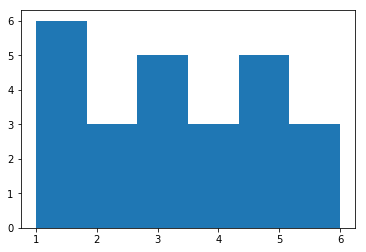

In [774]:
game.plot_die()

In [760]:
roll_combat_die(sides=6, dies=2)

NameError: name 'roll_combat_die' is not defined

In [4]:
cards = ['monster', 'treasure', 'merchant', 'resting', 'event', 'trap']
cards_effects = {}
cards = {'monster': {}, 
         'treasure': {}, 
         'merchant': {}, 
         'resting': {}, 
         'event': {}, 
         'trap': {}}

In [107]:
print("Welcome to Mini Rogue! Ready to play? Y/N")
play = input()
if play.lower() == 'yes' or play.lower() == 'y':
    print("\nAwesome! What level of dificulty?")
    print("[1] Casual \n[2] Normal \n[3] Hard \n[4] Impossible")
    difficulty = input()
    while not check(difficulty, ['1','2','3','4']):
        difficulty = input()
    difficulties = {'1': [1,5,5,6], '2': [0,5,3,6], '3': [0,4,2,5], '4': [0,3,1,3]}
    game = MiniRogue(*difficulties[difficulty])
#     while game.alive or not game.win:
#     game.life = 20
    game.start()

else:
    print("Exiting...")

Welcome to Mini Rogue! Ready to play? Y/N
y

Awesome! What level of dificulty?
[1] Casual 
[2] Normal 
[3] Hard 
[4] Impossible
1

You've entered the cave to Level 1: Black Sewers

Character stats: HP 5 | Armor 1 | Gold 5 | Food 6 | XP 0 | Rank 1 | Spells None

You've entered Area 1 from Level 1
>> Checkpoint - Game saved. <<
Area 1: [X] -> 2[] -> [] -> 2[]
You've encountered: treasure

You've found 1 gold piece.
Character stats: HP 5 | Armor 1 | Gold 6 | Food 6 | XP 0 | Rank 1 | Spells None

Roll a 5 or more on a die to find a special item. Press any key to roll.

-------------------------------------------------------------------------------------
d6 roll: 4
Sorry, it was "just" gold...
Area 1: [] -> 2[X] -> [] -> 2[]
You've encountered: event and monster
Choose one to encounter:
[1] event 
[2] monster
1
-------------------------------------------------------------------------------------

Roll a die to see what you will encounter. Press any key to roll.

----------------------------

KeyboardInterrupt: 

In [121]:
for i in [1,2,3,4,5]:
    print(int(i / 2 + 0.5) + 1)

2
2
3
3
4


In [1458]:
game.blueprints[game.rank-1][-1:][0]

7

In [1457]:
game.dungeon_area

15

In [ ]:
.lower() bug without input, end game after area 14

In [1435]:
game.stats()

Character stats: HP 20 | Armor 1 | Gold 5 | Food 6 | XP 0 | Rank 1 | Spells None
Dungeon stats: Level 1 (Black Sewers) | Area 1


In [1434]:
game.gain_xp(-1)